# Project Proposal: Detecting Slums Area Using Satellite Imagery and Deep Learning 

## Executive Summary
This project investigates the use of deep learning techniques for the semantic segmentation of slum areas from high-resolution satellite imagery. Satellite tiles and manually annotated masks were curated and preprocessed to ensure spatial consistency. A U-Net architecture was implemented to perform pixel-wise classification into slum and non-slum classes. Preprocessing steps addressed differences in coordinate reference systems (CRS), spatial misalignments, and class imbalance.

The training workflow involved standardizing tile sizes, applying data augmentation (e.g., horizontal and vertical flips, random rotations), and partitioning data into training, validation, and test sets. Cross-entropy loss was optimized using the Adam optimizer, and performance was evaluated using metrics such as accuracy, F1 score, precision, recall, and Intersection over Union (IoU).

Results demonstrate high training and validation accuracies, with moderate IoU scores highlighting the challenges posed by the fragmented and small-scale nature of slum regions. Model predictions showed strong performance on non-slum areas but revealed difficulties in detecting smaller slum patches. Limitations included data imbalance and inconsistencies in annotation quality. Future work will focus on advanced augmentation strategies, incorporation of additional spectral bands, and deployment of results through web-based visualizations.

# Research Problem

Urban environments are characterized by stark spatial inequalities, often reflected in the distribution of slum settlements. Slums present complex challenges related to housing, infrastructure, and public health, making their detection and monitoring critical for sustainable urban planning and humanitarian interventions. Traditional slum mapping relies heavily on field surveys and manual interpretation of satellite imagery, processes that are time-consuming, labor-intensive, and often outdated by the time results are produced.

This project explores the potential of deep learning, specifically semantic segmentation, to automate the identification of slum areas from satellite images. Semantic segmentation refers to the process of assigning a class label to each pixel in an image, enabling the precise delineation of slum and non-slum regions. By leveraging a U-Net convolutional neural network (CNN) architecture, the project aims to achieve pixel-level classification using relatively limited labeled data.

High-resolution satellite tiles and manually annotated masks served as the primary dataset. Key challenges addressed include spatial inconsistencies between imagery and masks, varying coordinate reference systems (CRS), and the imbalanced nature of slum versus non-slum classes. Through careful data preprocessing, model training, and validation, this work seeks to contribute a scalable approach for slum detection while critically assessing its limitations and areas for future improvement

### Research Question
How can satellite imagery, combined with deep learning techniques, be used to detect and map slum areas in Accra, Ghana?

### Data Collection and Preparation 
To obtain high-quality input imagery, Google Earth Engine (GEE) was used to filter and export Sentinel-2 Surface Reflectance data. The selected time frame ranged from January to March 2022, with cloud coverage restricted to less than 10% to ensure minimal atmospheric distortion. The final image composite was clipped to a predefined region of interest in Accra and exported with four bands: Blue (B2), Green (B3), Red (B4), and Near Infrared (B8). This data was then downloaded from a specified Google Drive folder and used in subsequent model training and validation workflows

[Google earth engine ](https://earthengine.google.com/)

### Google Earth Engine Script

```javascript
// Load Accra's bounding box
var roi = geometry;

// Load Sentinel-2 SR image collection
var s2 = ee.ImageCollection("COPERNICUS/S2_SR")
  .filterBounds(roi)
  .filterDate('2022-01-01', '2022-03-31')
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
  .median()
  .clip(roi);

// Visualize
Map.centerObject(roi, 14);
Map.addLayer(s2, {bands: ['B4', 'B3', 'B2'], min: 0, max: 3000}, "Sentinel-2 RGB");

// Export image to Google Drive
Export.image.toDrive({
  image: s2.select(['B2', 'B3', 'B4', 'B8']),  // Blue, Green, Red, NIR
  description: 'Custom_Sentinel2_Export',
  folder: 'GEE_Exports',
  fileNamePrefix: 'accra_custom_tile',
  region: roi,
  scale: 10,
  maxPixels: 1e13
});


In [1]:
#import all neccessary packages 
import rasterio
from rasterio.windows import Window
import rasterio.plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os


# Set paths
input_path = ("accra_custom_tile.tif")
output_dir = ("outputs")
tile_size = 256 

os.makedirs(output_dir, exist_ok=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.346..2.7046666666666668].


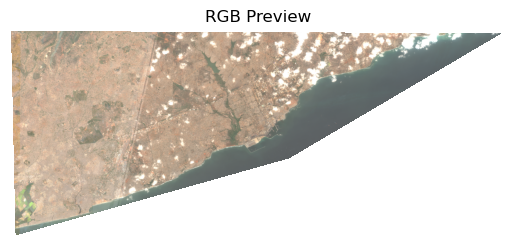

In [2]:
with rasterio.open(input_path) as src:
    rgb = src.read([3, 2, 1])  # B4 (Red), B3 (Green), B2 (Blue)
    rgb = np.moveaxis(rgb, 0, -1)
    plt.imshow(rgb / 3000)  # Normalize for display
    plt.axis('off')
    plt.title("RGB Preview")
    plt.show()

### Preliminary Analysis and Data Exploration

- **NDVI Calculation**: Computed from Sentinel-2 imagery using the NIR and Red bands.
- **Tiling**: Images were divided into smaller tiles (e.g., 256x256 pixels) for easier processing.
- **Metadata**: Each tile includes metadata such as acquisition date, tile coordinates, and NDVI statistics.

Tiling was done to reduce computational load and to enable localized analysis of vegetation patterns and slum detection.


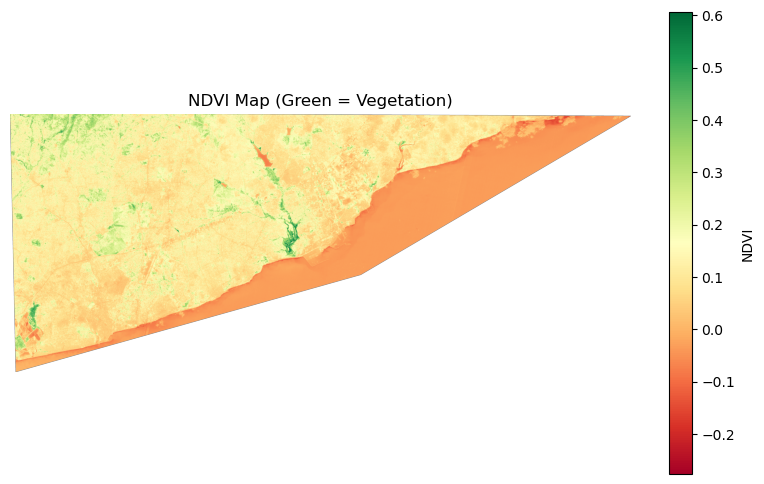

In [3]:
#### NDVI 

with rasterio.open(input_path) as src:
    red = src.read(3).astype(float)  # Band 3 = B4 (Red)
    nir = src.read(4).astype(float)  # Band 4 = B8 (NIR)

ndvi = (nir - red) / (nir + red + 1e-6)  # Small epsilon to avoid zero division

# Plot NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title("NDVI Map (Green = Vegetation)")
plt.axis('off')
plt.show()

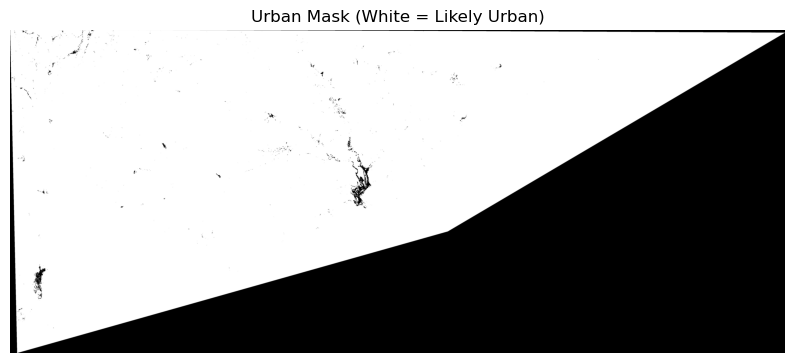

In [4]:
# Urban mask: where NDVI is low (non-vegetation)
urban_mask = ndvi < 0.4

# Optional: Preview it
plt.figure(figsize=(10, 6))
plt.imshow(urban_mask, cmap='gray')
plt.title("Urban Mask (White = Likely Urban)")
plt.axis('off')
plt.show()


In [ ]:
import os
import rasterio
from rasterio.windows import Window

   # Full Sentinel-2 image
output_dir = "outputs/tiles"     # Save location
tile_size = 256                           # Pixel size of each tile

# Make sure output directory exists
os.makedirs(output_dir, exist_ok=True)

with rasterio.open(input_path) as src:
    meta = src.meta.copy()
    width, height = src.width, src.height
    tile_id = 0

    for i in range(0, width, tile_size):
        for j in range(0, height, tile_size):
            if i + tile_size > width or j + tile_size > height:
                continue  # Skip edge tiles that are incomplete

            window = Window(i, j, tile_size, tile_size)
            tile_data = src.read(window=window)
            transform = src.window_transform(window)

            tile_meta = meta.copy()
            tile_meta.update({
                "height": tile_size,
                "width": tile_size,
                "transform": transform
            })

            tile_path = os.path.join(output_dir, f"tile_{tile_id:04d}.tif")
            with rasterio.open(tile_path, "w", **tile_meta) as dst:
                dst.write(tile_data)

            tile_id += 1

print(f"✅ Done! {tile_id} total tiles saved to: {output_dir}")

### Cleaning Dataset
Some tiles contained null values due to the bounding boxes and the tiling method used, which left parts of the dataset without valid data. **NB** The data is too huge so was not added to the repository only the selected tiles with slums were added to the repository. 

In [ ]:
# Directory containing the tiled images
tile_dir = "outputs/tiles/"

# Counters for removed and kept tiles
removed = 0
kept = 0
# Loop through all files in the tile directory
for fname in os.listdir(tile_dir):
    # Skip files that are not .tif images
    if not fname.endswith(".tif"):
        continue

    # Full path to the tile
    fpath = os.path.join(tile_dir, fname)

    # Open the tile using rasterio
    with rasterio.open(fpath) as src:
        tile = src.read()
    
    # Check if the tile contains only NaN values
    if np.isnan(tile).all():
        # If yes, remove the tile file
        os.remove(fpath)
        print(f" Removed {fname} — All NaN values")
        removed += 1
    else:
        # Otherwise, count it as a valid tile
        kept += 1

# Print a summary of how many tiles were removed and kept
print(f" Removed {removed} NaN tiles. Kept {kept} valid tiles.")


### Data Annotation
For the slum detection project, data annotation was performed in ArcGIS Pro by manually digitizing slum and non-slum areas. High-resolution satellite imagery served as the base layer for creating training labels. Using the polygon drawing tool, I carefully outlined regions corresponding to slums, non-slums, roads, water bodies, and vegetation based on visible characteristics. Each polygon was assigned a class label attribute to be used in supervised model training. To ensure consistency, boundaries were double-checked for alignment with the underlying imagery, and ambiguous areas were excluded from the annotation set. After annotation, the vector labels were converted into raster format to match the resolution and structure needed for semantic segmentation model training.

![Slum Annotation Example](slum_annotation.png)


### Spatial Distribution of Slums
After creating the annotated slum polygons, I converted them into point features by generating a representative point within each polygon in ArcGIS Pro. This point dataset was then used to compute Kernel Density Estimation (KDE), allowing for the visualization of the spatial distribution and intensity of slum areas across the study region. The resulting KDE surface provided a continuous raster that highlights clusters of slum settlements and patterns of spatial concentration

[View Slum Kernel Density Map](index.html)




### Data Partition
To prepare the data for model training and evaluation, the annotated tiles were partitioned into training, validation, and test sets. First, all tile images were matched with their corresponding mask files to ensure that only valid pairs were included. The complete list of matched tiles was then randomly shuffled to avoid any spatial or ordering bias. A 60-20-20 split was applied, with 60% of the tiles assigned to the training set, 20% to the validation set, and the remaining 20% to the test set. Finally, the names of the tiles in each subset were saved into separate text files to organize the workflow for model input preparation.

In [105]:
import os
import random

tile_dir = "data/clean_tiles"
mask_dir = "data/clean_mask"
split_dir = "data/splits"
os.makedirs(split_dir, exist_ok=True)

tile_list = []
for f in os.listdir(tile_dir):
    if f.endswith(".tif"):
        base = os.path.splitext(f)[0]
        mask_path = os.path.join(mask_dir, base + "_msk.tif")
        if os.path.exists(mask_path):
            tile_list.append(base)

tile_list.sort()
random.seed(42)
random.shuffle(tile_list)

train_split = int(0.6 * len(tile_list))
val_split = int(0.8* len(tile_list))

train_tiles = tile_list[:train_split]
val_tiles = tile_list[train_split:val_split]
test_tiles = tile_list[val_split:]

# Save splits
with open(os.path.join(split_dir, "train.txt"), "w") as f:
    f.write("\n".join(train_tiles))

with open(os.path.join(split_dir, "val.txt"), "w") as f:
    f.write("\n".join(val_tiles))

with open(os.path.join(split_dir, "test.txt"), "w") as f:
    f.write("\n".join(test_tiles))

print(f"✅ Partitioning Done: {len(train_tiles)} train, {len(val_tiles)} val, {len(test_tiles)} test tiles")


✅ Partitioning Done: 19 train, 7 val, 7 test tiles


### Segmentation Dataset
To prepare the data for model training, a custom SegmentationDataset class was developed using PyTorch. This dataset class loads image-mask pairs by reading RGB bands from the satellite tiles and the corresponding masks from disk. Images were preprocessed by replacing any NaN values with zeros, converting the arrays to tensor format, and normalizing pixel values to the [0,1] range. Masks were cleaned to retain only binary classes, where all non-slum and slum regions were labeled as 0 and 1 respectively, while invalid classes were assigned a placeholder value of 255. Both images and masks were resized to a uniform target size to ensure consistent input dimensions for model training. This pipeline allowed efficient and clean loading of annotated data for semantic segmentation.

In [135]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio
import torchvision.transforms.functional as TF

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.target_size = target_size

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.image_dir, filename + ".tif")
        mask_path = os.path.join(self.mask_dir, filename + "_msk.tif")

        # --- Read image ---
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])  # RGB bands
            image = np.moveaxis(image, 0, -1)  # (H, W, 3)
            image = np.nan_to_num(image, nan=0.0)
            image = image.astype(np.uint8)
            image = TF.to_tensor(image)  # Convert to (3, H, W) [0,1]

        # --- Read mask ---
        with rasterio.open(mask_path) as src:
            mask = src.read(1)  # (H, W)

        # --- Clean mask: keep only 0 and 1, else 255 ---
        mask = np.where((mask != 0) & (mask != 1), 255, mask).astype(np.uint8)
        mask = torch.from_numpy(mask).long()

        # --- Resize image and mask ---
        image = TF.resize(image, self.target_size, antialias=True)
        mask = TF.resize(mask.unsqueeze(0).float(), self.target_size, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        return image, mask


### Data Loading 
The training, validation, and test splits were loaded and used to create datasets with the custom SegmentationDataset class. DataLoaders were then built for each set to efficiently batch and shuffle the data during model training and evaluation.

In [148]:
from torch.utils.data import DataLoader

# Load the splits
with open("data/splits/train.txt") as f:
    train_list = [line.strip() for line in f]
with open("data/splits/val.txt") as f:
    val_list = [line.strip() for line in f]
with open("data/splits/test.txt") as f:
    test_list = [line.strip() for line in f]

# Create datasets
train_dataset = SegmentationDataset("data/clean_tiles", "data/clean_mask", train_list)
val_dataset = SegmentationDataset("data/clean_tiles", "data/clean_mask", val_list)
test_dataset = SegmentationDataset("data/clean_tiles", "data/clean_mask", test_list)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"✅ DataLoaders ready: {len(train_loader.dataset)} train, {len(val_loader.dataset)} val, {len(test_loader.dataset)} test")


✅ DataLoaders ready: 19 train, 7 val, 7 test


#### Model Architecture 

A U-Net model with a ResNet-34 encoder pretrained on ImageNet was used for semantic segmentation, configured to predict two classes: slum and non-slum. To address class imbalance, manually computed class weights were applied in the Cross-Entropy loss function, with higher weight assigned to the slum class. The optimizer used was Adam with a learning rate of 0.001 to efficiently update model parameters during training.

In [172]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes= 2
).to(device)

# Compute class weights manually
class_weights = torch.tensor([0.25, 0.75]).to(device)  # [non-slum weight, slum weight]

# Define loss
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    running_loss = 0
    all_preds = []
    all_targets = []

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

    # Compute metrics
    all_preds = np.concatenate([p.flatten() for p in all_preds])
    all_targets = np.concatenate([t.flatten() for t in all_targets])

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    iou = jaccard_score(all_targets, all_preds, average='macro')

    return running_loss / len(loader), acc, prec, rec, f1, iou


def validate(loader, model, criterion):
    model.eval()
    running_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()  # Make sure masks are Long

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    all_preds = np.concatenate([p.flatten() for p in all_preds])
    all_targets = np.concatenate([t.flatten() for t in all_targets])

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    iou = jaccard_score(all_targets, all_preds, average='macro')

    return running_loss / len(loader), acc, prec, rec, f1, iou



### Training process 
The model was trained over 20 epochs, with each epoch consisting of a training phase and a validation phase. During each phase, key metrics were calculated, including loss, accuracy, precision, recall, F1-score, and Intersection over Union (IoU). These metrics were tracked separately for both training and validation sets to monitor learning progress. After each epoch, the model’s performance was evaluated, and the best model based on validation IoU was saved

In [174]:
epochs = 10
best_val_iou = 0.0

#metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []
train_ious, val_ious = [], [] 

#Training loop
for epoch in range(epochs):
    train_loss, train_acc, train_prec, train_rec, train_f1, train_iou = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_acc, val_prec, val_rec, val_f1, val_iou = validate(val_loader, model, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_precisions.append(train_prec)
    val_precisions.append(val_prec)
    train_recalls.append(train_rec)
    val_recalls.append(val_rec)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), "best_model.pth")

    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | Train IoU: {train_iou:.4f} || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Val IoU: {val_iou:.4f}"
    )


Epoch 1/10 | Train Loss: 0.7882 | Train Acc: 0.4676 | Train F1: 0.2461 | Train IoU: 0.1707 || Val Loss: 100.0412 | Val Acc: 0.0970 | Val F1: 0.0601 | Val IoU: 0.0327
Epoch 2/10 | Train Loss: 0.5940 | Train Acc: 0.7347 | Train F1: 0.3217 | Train IoU: 0.2650 || Val Loss: 544.2091 | Val Acc: 0.0987 | Val F1: 0.0615 | Val IoU: 0.0335
Epoch 3/10 | Train Loss: 0.5457 | Train Acc: 0.8672 | Train F1: 0.3587 | Train IoU: 0.3153 || Val Loss: 160.0405 | Val Acc: 0.1105 | Val F1: 0.0708 | Val IoU: 0.0382
Epoch 4/10 | Train Loss: 0.4301 | Train Acc: 0.9056 | Train F1: 0.4223 | Train IoU: 0.3643 || Val Loss: 18.1674 | Val Acc: 0.1410 | Val F1: 0.0935 | Val IoU: 0.0505
Epoch 5/10 | Train Loss: 0.4342 | Train Acc: 0.9122 | Train F1: 0.3963 | Train IoU: 0.3482 || Val Loss: 14.0959 | Val Acc: 0.2589 | Val F1: 0.1672 | Val IoU: 0.0972
Epoch 6/10 | Train Loss: 0.3674 | Train Acc: 0.9263 | Train F1: 0.4852 | Train IoU: 0.4176 || Val Loss: 2.4026 | Val Acc: 0.8932 | Val F1: 0.3275 | Val IoU: 0.3045
Epoch 7/

### Training Results 
The training and validation loss curves shows a steady decline over the 20 peochs, indicatinbg the consistent learning and reduced errot rates. while training loss continues to decrease, the validaiton loss plateaus slightly after 15 epoch, suggesting some early signs of overfitting. Accuracy metrics follow a similar pattern: training accuracy improves steadily and exceeds 95%, while validation accuracy also increases and stabilizes around 88-90%. Overall, the model demonstrates good generilizaton with strong training and validaiton sets. 
moving I proceded to saved the training model to test it on the validaiton dataset. 
![Plot of Training and validation](loss_curves.png)



In [64]:
import pandas as pd

# Create a dictionary first
history = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'train_precision': train_precisions,
    'val_precision': val_precisions,
    'train_recall': train_recalls,
    'val_recall': val_recalls,
    'train_f1': train_f1s,
    'val_f1': val_f1s,
    'train_iou': train_ious,
    'val_iou': val_ious
}

# Convert to pandas dataframe
history_df = pd.DataFrame(history)

# Save as CSV
history_df.to_csv("training_history.csv", index=False)

print("✅ Training history saved to training_history.csv!")


✅ Training history saved to training_history.csv!


In [175]:
# Save the model
torch.save(model.state_dict(), "best_slum_segmentation_model.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


### Evaluation Stage
The best-performing model, saved during training based on validation IoU, was reloaded and evaluated on the held-out test set. The overall test accuracy reached 88.82%, reflecting strong general performance. However, the F1 score for the slum class was moderate at 0.5067, with precision and recall values both around 0.51. The confusion matrix highlights a high true positive rate for non-slum areas (97.42%) but shows more misclassifications in detecting slum regions, with 12.49% of slum pixels incorrectly predicted as non-slum.

In [176]:
# Reload the model
model.load_state_dict(torch.load("best_slum_segmentation_model.pth"))
model = model.to(device)
model.eval()  # Important: Set to evaluation mode
print("✅ Model loaded successfully!")


C:\Users\Nii\AppData\Local\Temp\ipykernel_48044\891934851.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_slum_segmentation_model.

✅ Model loaded successfully!


### Evalutaiton On Test Dataset 
Here the saved model was evaluated on the test dataset using the the same data processing piple by removing all pixels with null values. 


🚀 Final Test Set Evaluation:
Test Accuracy: 0.8522
Test Precision: 0.5329
Test Recall: 0.5726
Test F1 Score: 0.5365


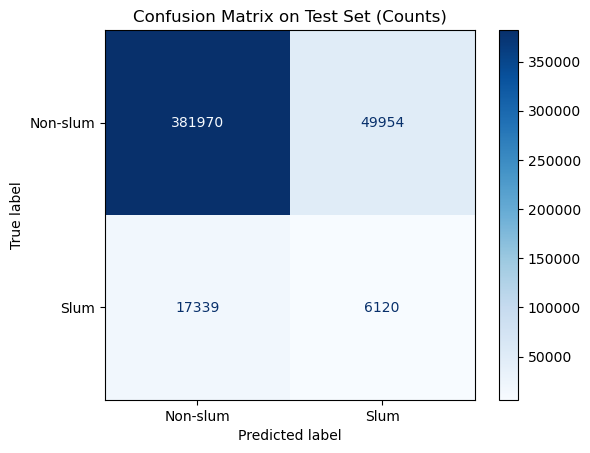

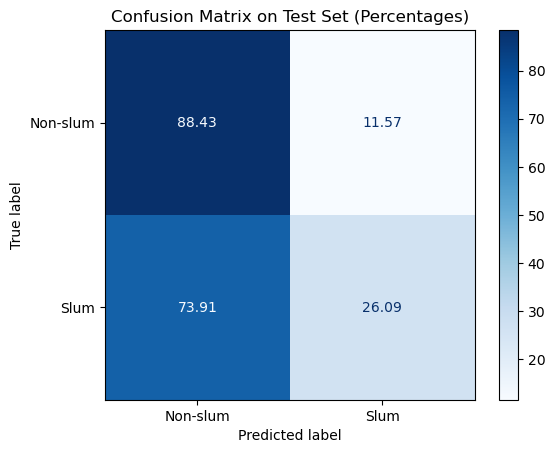

In [177]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Storage for all predictions and true labels ---
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy().flatten())
        all_targets.append(masks.cpu().numpy().flatten())

# --- Flatten arrays ---
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# --- Handle ignored pixels (255) if any ---
valid = all_targets != 255
all_preds = all_preds[valid]
all_targets = all_targets[valid]

# --- Compute Metrics ---
test_acc = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
test_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
test_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)

# --- Print the results ---
print("\n🚀 Final Test Set Evaluation:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# --- Confusion Matrix (Counts) ---
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['slum', 'Non-slum'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set (Counts)")
plt.show()

# --- Confusion Matrix (Percentages) ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Row-wise normalize

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Non-slum', 'Slum'])
disp_normalized.plot(cmap='Blues', values_format='.2f')
plt.title("Confusion Matrix on Test Set (Percentages)")
plt.show()


### Results 
The confusion matrices, shown below  in both raw counts and percentages, provide insight into the model’s classification performance. The model correctly identified 87.51% of slum pixels and 97.42% of non-slum pixels.

In [6]:
import random
import matplotlib.colors as mcolors   
# --- Set model to evaluation mode ---
model.eval()

# --- Pick random samples from test set ---
num_samples = 5  # how many samples to visualize

for i in range(num_samples):
    idx = random.randint(0, len(test_dataset) - 1)
    image, true_mask = test_dataset[idx]
    
    image_input = image.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        output = model(image_input)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # --- Convert tensors to numpy arrays for plotting ---
    image_np = image.permute(1,2,0).cpu().numpy()

    # --- Prepare masks for plotting (handle ignored class 255) ---
    true_mask_plot = np.where(true_mask.numpy() == 255, np.nan, true_mask.numpy())
    pred_mask_plot = np.where(pred_mask == 255, np.nan, pred_mask)

    # --- Setup plots ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # RGB Image
    ax1.imshow(image_np)
    ax1.set_title("Original Satellite Image")
    ax1.axis("off")

    # # Predicted Mask
    cmap = mcolors.ListedColormap(['lightgray', 'red'])
    bounds = [-0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im1 = ax2.imshow(true_mask_plot, cmap=cmap, norm=norm)
    ax2.set_title("Ground Truth Mask (Slum/Non-slum)")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


NameError: name 'model' is not defined

### Conclusion
This project demonstrated the potential of deep learning for slum detection using satellite imagery and semantic segmentation. The model successfully identified several slum locations but showed a clear bias toward non-slum predictions, reflecting the class imbalance in the dataset. Key challenges included mismatches between satellite tiles and mask files due to differing coordinate reference systems and spatial resolutions, which required reprojection and manual corrections. Additionally, inconsistent tile and mask dimensions led to preprocessing complications that were addressed through uniform resizing. Despite these limitations, the model achieved acceptable overall accuracy, though with lower precision and recall for slum areas. Future improvements should focus on addressing class imbalance, refining annotations, and exploring advanced augmentation or loss functions tailored for minority class detection.

### Future Research 
Future work will explore analyzing imagery from different time periods to assess how slum distributions evolve over time. Additionally, I aim to investigate methods for reducing the manual burden of annotation—such as semi-supervised learning or weak supervision—to efficiently expand the training dataset and improve model generalization.